In [1]:
import torchvision
import torch
from torchvision.datasets import ImageFolder

from PIL import Image
import os, os.path
from skimage import io

import torchvision.transforms as transforms

import pandas as pd
from torch.utils.data import Dataset

import numpy as np

torch.manual_seed(10)
np.random.seed(10)

In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzip the data
!unzip /content/drive/MyDrive/LMU/SS2022/UDLSeminar/DiabeticRetinopathyGrading.zip

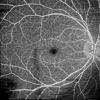

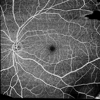

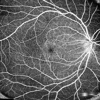

In [ ]:
# visualize the images
path = '/content/C. Diabetic Retinopathy Grading/1. Original Images/a. Training Set'
filename = os.listdir(path)
for i in range(3):
    im = Image.open(path + '/' + filename[i]) 
    im = im.resize((100,100))
    display(im)

In [ ]:
# get image size
path = '/content/C. Diabetic Retinopathy Grading/1. Original Images/a. Training Set'
filename = os.listdir(path)
for i in range(13):
    im = Image.open(path + '/' + filename[i])
    transform = transforms.ToTensor()
    display(transform(im).shape)

torch.Size([1, 1024, 1024])

torch.Size([1, 1024, 1024])

torch.Size([1, 1024, 1024])

torch.Size([1, 1024, 1024])

torch.Size([1, 1024, 1024])

torch.Size([1, 1024, 1024])

torch.Size([1, 1024, 1024])

torch.Size([1, 1024, 1024])

torch.Size([1, 1024, 1024])

torch.Size([1, 1024, 1024])

torch.Size([1, 1024, 1024])

torch.Size([1, 1024, 1024])

torch.Size([1, 1024, 1024])

# Constants

In [ ]:
IMAGE_SIZE = 512
NUM_CHANNELS = 1
BATCH_SIZE = 8
EPOCHS = 50
NUM_WORKERS = 0

TRAIN_SIZE = 511

ROOT_DIR = '/content/C. Diabetic Retinopathy Grading/1. Original Images/a. Training Set'
CSV_FILE = '/content/C. Diabetic Retinopathy Grading/2. Groundtruths/a. DRAC2022_ Diabetic Retinopathy Grading_Training Labels.csv'

PATH = '/content/drive/MyDrive/LMU/SS2022/UDLSeminar/saved_model'
MIN_PATH ='/content/drive/MyDrive/LMU/SS2022/UDLSeminar/min_loss_model'

NUM_CLASSES = 3

LEARNING_RATE = 1e-4
WEIGHT_DECAY = 5e-4

# Labels

In [ ]:
df = pd.read_csv(CSV_FILE)
df.iloc[:,1].unique()

array([0, 1, 2])

# Dataloader

In [ ]:
from torchvision.io import read_image

class CustomDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.annotations.iloc[idx, 0])
        # image = read_image(img_name)
        image = Image.open(img_name)
        annotation = self.annotations.iloc[idx, 1]
        annotation = annotation.astype('int')
        # sample = {'image': image, 'label': annotation}

        if self.transform:
            image = self.transform(image)

        return image, annotation

In [ ]:
transform = transforms.Compose([transforms.PILToTensor(),
                                transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                                transforms.ConvertImageDtype(torch.float)])

In [ ]:
dataset = CustomDataset(CSV_FILE, ROOT_DIR, transform)

In [ ]:
gen = torch.Generator()
gen.manual_seed(0)

In [ ]:
train_set, val_set = torch.utils.data.random_split(dataset, [TRAIN_SIZE, len(dataset) - TRAIN_SIZE],generator=gen)

len(train_set), len(val_set)

(511, 100)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)

In [ ]:
# images, labels = next(iter(train_loader))
# display(images[0].shape, labels[0])

tensor([0, 1, 2, 0, 0])

# MODEL

In [ ]:
!pip install transformers

In [ ]:
from transformers import SwinModel, SwinConfig

# Initializing a Swin microsoft/swin-tiny-patch4-window7-224 style configuration
configuration = SwinConfig( image_size = IMAGE_SIZE, num_channels = NUM_CHANNELS, num_labels = 3)

In [ ]:
from transformers import AutoFeatureExtractor, SwinForImageClassification

# download pretrained model
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
model = SwinForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224", config = configuration, ignore_mismatched_sizes=True)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- swin.embeddings.patch_embeddings.projection.weight: found shape torch.Size([96, 3, 4, 4]) in the checkpoint and torch.Size([96, 1, 4, 4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predic

In [ ]:
model.to(DEVICE)

In [ ]:
# inputs, labels = next(iter(train_loader))

# # forward + backward + optimize
# outputsClass = model(inputs)

In [ ]:
# outputsClass.logits.shape

torch.Size([32, 3])

# TRAIN - PYTORCH

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 11.9 MB/s 


In [ ]:
from torch.optim import AdamW
from torch import nn
from torchmetrics import F1Score

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay = WEIGHT_DECAY)

# set F1 score
f1 = F1Score(num_classes=NUM_CLASSES).to(DEVICE)

# train model without freezing the layers

---



In [ ]:
train_loss_values = []
train_f1 = []

val_loss_values = []
val_f1 = []

last_val_loss = 1000
min_val_loss = 100
patience = 3
triggertimes = 0

for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    val_loss = 0.0
    
    train_f1_epoch = 0.0
    val_f1_epoch = 0.0

    model.train()
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        
        loss = criterion(outputs.logits, labels)
        train_f1_epoch += f1(outputs.logits, labels)

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    avg_train_f1 = train_f1_epoch / len(train_loader) 

    train_loss_values.append(avg_train_loss)
    train_f1.append(avg_train_f1)

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            # forward + backward + optimize
            outputs = model(inputs)

            loss = criterion(outputs.logits, labels)
            val_f1_epoch += f1(outputs.logits, labels)

            val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_f1 = val_f1_epoch / len(val_loader) 

        if avg_val_loss < min_val_loss:
          print('New min val loss:', avg_val_loss)
          # save the model
          torch.save({'epoch': epoch,
                      'model_state_dict': model.state_dict(),
                      'optimizer_state_dict': optimizer.state_dict(),
                      'loss': loss,
                      }, MIN_PATH)
          min_val_loss = avg_val_loss

        # early stopping
        if avg_val_loss > last_val_loss:
            trigger_times += 1
            print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStop training.')
                # save the model
                torch.save({'epoch': epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss': loss,
                            }, PATH)
                break
        else:
            print('trigger times: 0')
            trigger_times = 0

        last_val_loss = avg_val_loss
        
        val_loss_values.append(avg_val_loss)
        val_f1.append(avg_val_f1)

    print(f'[Epoch: {epoch + 1}] train loss: {avg_train_loss:.3f} val loss:{avg_val_loss:.3f} ')
    print(f'[Epoch: {epoch + 1}] train f1: {avg_train_f1:.3f} val f1:{avg_val_f1:.3f} ')

print('Finished Training')

New min val loss: 0.960633227458367
trigger times: 0
[Epoch: 1] train loss: 0.992 val loss:0.961 
[Epoch: 1] train f1: 0.542 val f1:0.538 
Trigger Times: 1
[Epoch: 2] train loss: 0.976 val loss:0.968 
[Epoch: 2] train f1: 0.552 val f1:0.519 
trigger times: 0
[Epoch: 3] train loss: 0.967 val loss:0.962 
[Epoch: 3] train f1: 0.556 val f1:0.538 
Trigger Times: 1
[Epoch: 4] train loss: 0.950 val loss:0.971 
[Epoch: 4] train f1: 0.554 val f1:0.519 
Trigger Times: 2
[Epoch: 5] train loss: 0.955 val loss:0.989 
[Epoch: 5] train f1: 0.554 val f1:0.529 
trigger times: 0
[Epoch: 6] train loss: 0.934 val loss:0.974 
[Epoch: 6] train f1: 0.562 val f1:0.519 
Trigger Times: 1
[Epoch: 7] train loss: 0.938 val loss:0.995 
[Epoch: 7] train f1: 0.577 val f1:0.529 
trigger times: 0
[Epoch: 8] train loss: 0.947 val loss:0.980 
[Epoch: 8] train f1: 0.536 val f1:0.529 
New min val loss: 0.9203035969000596
trigger times: 0
[Epoch: 9] train loss: 0.929 val loss:0.920 
[Epoch: 9] train f1: 0.564 val f1:0.529 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np 

x = np.arange(EPOCHS)
y = train_loss_values
z = val_loss_values
 
# plot lines
plt.plot(x, y, label = "train")
plt.plot(x, z, label = "val")
plt.legend()
plt.show()

In [ ]:
# find the min training loss and the epoch number of that loss
np.argmin(val_loss_values), min(val_loss_values)

(32, 0.5944550404181848)

# Model with frozen layers

In [ ]:
# Freeze weights
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True


In [ ]:
train_loss_values = []
train_f1 = []

val_loss_values = []
val_f1 = []


In [ ]:

for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    val_loss = 0.0
    
    train_f1_epoch = 0.0
    val_f1_epoch = 0.0

    model.train()
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        
        loss = criterion(outputs.logits, labels)
        train_f1_epoch += f1(outputs.logits, labels)

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    avg_train_f1 = train_f1_epoch / len(train_loader) 

    train_loss_values.append(avg_train_loss)
    train_f1.append(avg_train_f1)

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            # forward + backward + optimize
            outputs = model(inputs)

            loss = criterion(outputs.logits, labels)
            val_f1_epoch += f1(outputs.logits, labels)

            val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_f1 = val_f1_epoch / len(val_loader) 
        
        val_loss_values.append(avg_val_loss)
        val_f1.append(avg_val_f1)

    print(f'[Epoch: {epoch + 1}] train loss: {avg_train_loss:.3f} train f1: {avg_train_f1:.3f} ')
    print(f'[Epoch: {epoch + 1}] val loss:{avg_val_loss:.3f} val f1:{avg_val_f1:.3f} ')

print('Finished Training')

[Epoch: 1] train loss: 1.157 train f1: 0.129 
[Epoch: 1] val loss:1.159 val f1:0.125 
[Epoch: 2] train loss: 1.161 train f1: 0.125 
[Epoch: 2] val loss:1.159 val f1:0.125 
[Epoch: 3] train loss: 1.161 train f1: 0.123 
[Epoch: 3] val loss:1.156 val f1:0.144 
[Epoch: 4] train loss: 1.160 train f1: 0.128 
[Epoch: 4] val loss:1.160 val f1:0.125 
[Epoch: 5] train loss: 1.156 train f1: 0.125 
[Epoch: 5] val loss:1.158 val f1:0.135 
[Epoch: 6] train loss: 1.158 train f1: 0.127 
[Epoch: 6] val loss:1.158 val f1:0.135 
[Epoch: 7] train loss: 1.156 train f1: 0.125 
[Epoch: 7] val loss:1.160 val f1:0.125 
[Epoch: 8] train loss: 1.156 train f1: 0.129 
[Epoch: 8] val loss:1.159 val f1:0.125 
[Epoch: 9] train loss: 1.161 train f1: 0.121 
[Epoch: 9] val loss:1.159 val f1:0.125 
[Epoch: 10] train loss: 1.155 train f1: 0.129 
[Epoch: 10] val loss:1.159 val f1:0.125 
[Epoch: 11] train loss: 1.159 train f1: 0.124 
[Epoch: 11] val loss:1.159 val f1:0.125 
[Epoch: 12] train loss: 1.157 train f1: 0.126 
[Ep

TypeError: ignored

In [ ]:
x = np.arange(EPOCHS)
y = np.array(train_f1)
z = np.array(val_f1)

# plot lines
plt.plot(x, y, label = "train f1")
plt.plot(x, z, label = "val f1")
plt.legend()
plt.show()

# Submission

In [ ]:
# unzip the data
!unzip /content/drive/MyDrive/LMU/SS2022/UDLSeminar/DiabeticRetinopathyGradingTest.zip

In [ ]:
ROOT_TEST_DIR = '/content/C. Diabetic Retinopathy Grading/1. Original Images/b. Testing Set'

In [ ]:
!cd '/content/C. Diabetic Retinopathy Grading/1. Original Images/b. Testing Set' && ls > /content/test_filenames.csv

In [ ]:
!cat /content/test_filenames.csv

In [ ]:
csv_test_name = '/content/test_filenames.csv'

In [ ]:
from torchvision.io import read_image

# data loader for test images
class CustomTestDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.annotations = pd.read_csv(csv_file, header=None)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.annotations.iloc[idx, 0])
        # image = read_image(img_name)
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image

In [ ]:
transform = transforms.Compose([transforms.PILToTensor(),
                                transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                                transforms.ConvertImageDtype(torch.float)])

In [ ]:
test_dataset = CustomTestDataset(csv_test_name,ROOT_TEST_DIR, transform)

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                           num_workers=NUM_WORKERS, pin_memory=True)

In [ ]:
# image = next(iter(test_loader))
# display(image.shape)

torch.Size([1, 1, 512, 512])

# Test Loop

In [ ]:
from torch.optim import AdamW
from transformers import AutoFeatureExtractor, SwinForImageClassification
from transformers import SwinModel, SwinConfig

# Initializing a Swin microsoft/swin-tiny-patch4-window7-224 style configuration
configuration = SwinConfig( image_size = IMAGE_SIZE, num_channels = NUM_CHANNELS, num_labels = 3)
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
model = SwinForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224", config = configuration, ignore_mismatched_sizes=True)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay = WEIGHT_DECAY)

checkpoint = torch.load(MIN_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']


/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- swin.embeddings.patch_embeddings.projection.weight: found shape torch.Size([96, 3, 4, 4]) in the checkpoint and torch.Size([96, 1, 4, 4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predic

In [ ]:
predictions = torch.zeros((len(test_dataset), 3))
model.to(DEVICE)

model.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data
        inputs = inputs.to(DEVICE)
        
        # forward + backward + optimize
        outputs = model(inputs)

        predictions[i, :] = outputs.logits.cpu()



In [ ]:
predictions = torch.nn.functional.softmax(predictions, dim=1).numpy()

In [ ]:
# Calculate the pseudo-loss
test_loss = nn.CrossEntropy()
test_loss(predictions.argmax(axis=1), predictions)

NameError: ignored

In [ ]:
predicted_classes = predictions.argmax(axis=1)
predicted_classes.shape

(386,)

In [ ]:
submission = pd.read_csv(csv_test_name, header=None)
submission.columns = ['case']
submission['class'] =  predicted_classes

In [ ]:
submission

,case,class
0,1000.png,2
1,1001.png,1
2,1002.png,1
3,1003.png,2
4,1004.png,2
...,...,...
381,995.png,2
382,996.png,2
383,997.png,1
384,998.png,2


In [ ]:
submission['P0'] = predictions[:,0]
submission['P1'] = predictions[:,1]
submission['P2'] = predictions[:,2]

In [ ]:
submission.to_csv('/content/drive/MyDrive/LMU/SS2022/UDLSeminar/submission_csv.csv')